# Задание 2
Эксперимент проходил с 2022-04-04 по 2022-04-10 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from scipy import stats
from tqdm import tqdm

from read_db.CH import Getch

%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})

Условия:
- **Тест**: АB
- **Гипотеза**: Новый алгоритм во 2-й группе приведет к увеличению CTR (но будем использовать двустороннюю альтернативную гипотезу, так мы заранее не знаем, увиличится или уменьшится CTR).
- **Метрика**: CTR, сглаженный CTR
- **Даты**: '2022-04-04' по '2022-04-10'
- **Тестовая группа**: 2
- **Контрольная группа**: 1
- **$\alpha$**: 0.05


## Посмотрим на данные

In [3]:
ab_test_query = """
    SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes / views as ctr
    FROM simulator_20220420.feed_actions 
    WHERE toDate(time) between '2022-04-04' and '2022-04-10'
        and exp_group in (1, 2)
    GROUP BY exp_group, user_id
"""

In [4]:
ab_test_data = Getch(ab_test_query).df

In [5]:
ab_test_data.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [6]:
# Размеры выборок
ab_test_data.groupby('exp_group').count()[['user_id']]

,user_id
exp_group,
1,10079
2,9952


В группах +- одинаковое количество юзеров

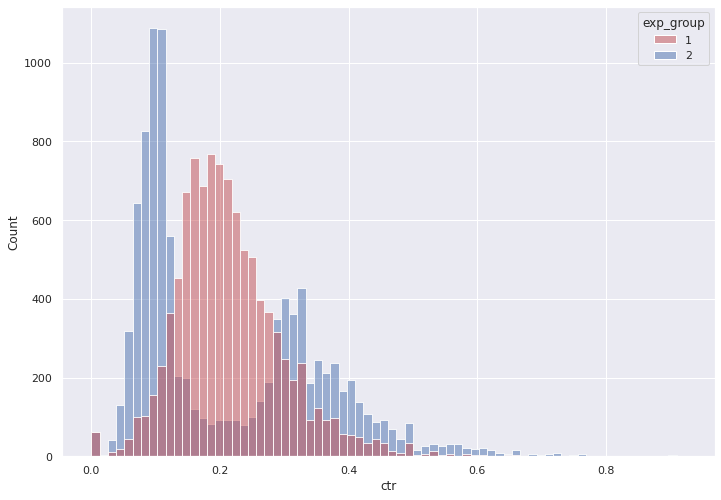

In [7]:
# Посмотрим глазами на группы
groups = sns.histplot(
    data=ab_test_data, 
    x='ctr', 
    hue='exp_group', 
    palette=['r', 'b'],
    alpha=0.5,
    kde=False
)

Забавная картина. В тестовой группе (2) получили бимодальное распределение. Возможно, тестовая группа имеет 2 подгруппы, разделенный по какому-то неизвестному для нас признаку.  Часть людей стала лайкать больше, но большая часть стала лайкать меньше.     
Контрольная группа (1) выглядит ожидаемо.  
Группы однозначно отличаются, но я бы такое не стала катить, пока не нашла причину разделения тестовой группы на две подгруппы. Будет интересно посмотреть, что покажут тесты.

In [8]:
# посмотрим описательные статистики
ab_test_data[['exp_group', 'ctr']].groupby('exp_group').describe()

ctr                                                        \
             count      mean      std  min       25%       50%       75%   
exp_group                                                                  
1          10079.0  0.215605  0.08416  0.0  0.160097  0.203125  0.257654   
2           9952.0  0.214419  0.14418  0.0  0.095238  0.142857  0.325000   

                     
                max  
exp_group            
1          0.722222  
2          0.923077

## t-test для сравнения CRT

In [9]:
stats.ttest_ind(ab_test_data[ab_test_data['exp_group'] == 2]['ctr'], # test
                ab_test_data[ab_test_data['exp_group'] == 1]['ctr'], # control
                equal_var=False)

Ttest_indResult(statistic=-0.7094392041270486, pvalue=0.4780623130874935)

T-test не прокрасился, но это из-за того, что средние значения ctr в группах +- одинаковые.

## Тест Манна-Уитни для сравнения CRT

In [10]:
stats.mannwhitneyu(ab_test_data[ab_test_data['exp_group'] == 2]['ctr'],
                   ab_test_data[ab_test_data['exp_group'] == 1]['ctr'],
                   alternative='two-sided')

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

А это тест ожидаемо показал, что существуют различия в группах, но не факт, что различия в средних.

## t-test на сглаженном CRT

In [11]:
# возьмем готовую функцию из лекции
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [12]:
global_ctr_test = ab_test_data[ab_test_data['exp_group'] == 2]['likes'].sum() / ab_test_data[ab_test_data['exp_group'] == 2]['views'].sum()
global_ctr_control = ab_test_data[ab_test_data['exp_group'] == 1]['likes'].sum() / ab_test_data[ab_test_data['exp_group'] == 1]['views'].sum()

In [13]:
test_group = ab_test_data[ab_test_data['exp_group'] == 2].copy()
control_group = ab_test_data[ab_test_data['exp_group'] == 1].copy()

In [14]:
test_group['smothed_ctr'] = test_group.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_test, 5), axis=1)

In [15]:
control_group['smothed_ctr'] = control_group.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_control, 5), axis=1)

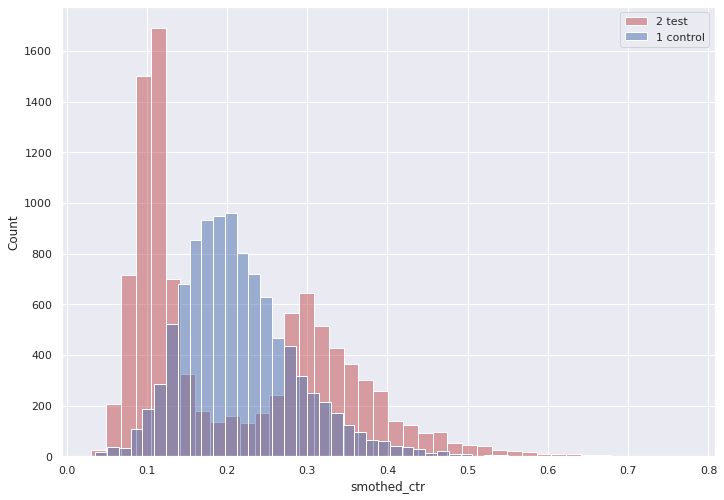

In [16]:
# Посмотрим что получилось на картинке
sns.histplot(
    data=test_group, 
    x='smothed_ctr', 
    hue='exp_group', 
    palette=['r'],
    alpha=0.5,
    kde=False,
    label='2 test',
    bins=40
)
sns.histplot(
    data=control_group, 
    x='smothed_ctr', 
    hue='exp_group', 
    palette=['b'],
    alpha=0.5,
    kde=False,
    label='1 control',
    bins=40
)
plt.legend()

In [17]:
# посчитаем тест
stats.ttest_ind(test_group['smothed_ctr'],
                control_group['smothed_ctr'],
                equal_var=False)

Ttest_indResult(statistic=-2.2841320431616983, pvalue=0.0223769815558559)

На уровне значимости 0.05 тест прокрасился.  
Посмотрим как изменились средние.

In [18]:
test_group['ctr'].mean(), control_group['ctr'].mean()

(0.21441927347479375, 0.21560459841296287)

In [19]:
test_group['smothed_ctr'].mean(), control_group['smothed_ctr'].mean()

(0.21073955503259234, 0.21402549608884142)

In [20]:
# посчитаем тест
stats.mannwhitneyu(test_group['smothed_ctr'],
                   control_group['smothed_ctr'],
                   alternative='two-sided')

MannwhitneyuResult(statistic=43381083.0, pvalue=1.6163964114270227e-61)

Тест Манна-Уитни тоже показал различия

## Пуассоновский бутстреп 

In [21]:
# еще раз воспользуемся готовой функцией из лекции
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [22]:
test_group.columns

Index(['exp_group', 'user_id', 'likes', 'views', 'ctr', 'smothed_ctr'], dtype='object')

In [23]:
ctr_test, ctr_control = bootstrap(test_group['likes'].to_numpy(), 
                                  test_group['views'].to_numpy(), 
                                  control_group['likes'].to_numpy(), 
                                  control_group['views'].to_numpy())

### t-test

In [34]:
stats.ttest_ind(ctr_test,
                ctr_control,
                equal_var=False)

Ttest_indResult(statistic=-278.2770500219398, pvalue=0.0)

Тест прокрасился. Судя по значению p-value, получившиеся группы даже не пересекаются.

### Тест Манна-Уитни

In [25]:
stats.mannwhitneyu(ctr_test,
                   ctr_control,
                   alternative='two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

Тест Манна-Уитни тоже прокрасился

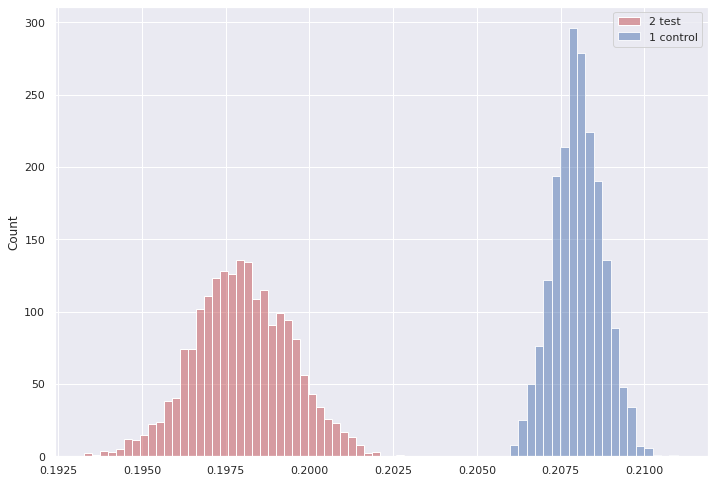

In [35]:
# посмотрим картинки
sns.histplot( 
    x=ctr_test, 
    alpha=0.5,
    kde=False,
    label='2 test',
    bins=40,
    color='r',
)
sns.histplot(
    x=ctr_control, 
    alpha=0.5,
    kde=False,
    label='1 control',
    bins=20,
    color='b',
)
plt.legend()

Как видно из картинки, распределения не пересекаются. И распределение тестовой группы находится левее, чем рапределение контрольной группы, что говорит нам о том, что групповой CTR с новым алгоритмом стал меньше.  
Еще хочу отметить, что у экспериментальной группы изменилась форма распределения, но я не знаю как это может повлиять на выводы.   

## Бакетное преобразование

В группах у нас примерно по 10к пользователей. Если поделим их на 50 бакетов, то в каждом бакете получим примерно по 200 пользователей – ок.

In [28]:
backet_query = """
    SELECT exp_group, bucket,
        sum(likes) / sum(views) as bucket_ctr,
        quantileExact(0.9)(ctr) as ctr9,
        count(distinct user_id) count_users
    FROM (SELECT exp_group, 
            xxHash64(user_id) % 50 as bucket,
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes / views as ctr
        FROM simulator_20220420.feed_actions 
        WHERE toDate(time) between '2022-04-04' and '2022-04-10'
            and exp_group in (1, 2)
        GROUP BY exp_group, bucket, user_id)
    GROUP BY exp_group, bucket
"""

In [29]:
backet_data = Getch(backet_query).df

In [30]:
backet_data.head()

,exp_group,bucket,bucket_ctr,ctr9,count_users
0,1,0,0.196481,0.307692,200
1,2,0,0.194262,0.384615,189
2,1,1,0.211887,0.318182,196
3,2,1,0.215328,0.467742,196
4,1,2,0.206271,0.322314,211


Посмотрим на распределения бакетного CTR

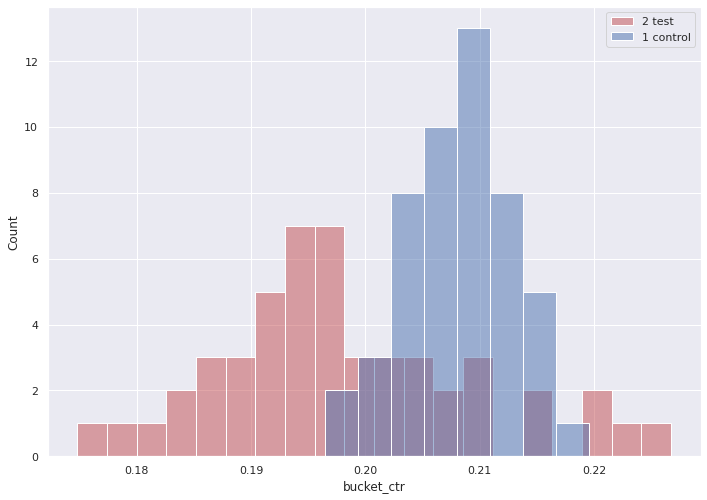

In [31]:
sns.histplot( 
    data=backet_data[backet_data['exp_group'] == 2],
    x='bucket_ctr', 
    alpha=0.5,
    kde=False,
    label='2 test',
    bins=20,
    color='r',
)
sns.histplot(
    data=backet_data[backet_data['exp_group'] == 1],
    x='bucket_ctr', 
    alpha=0.5,
    kde=False,
    label='1 control',
    # bins=20,
    color='b',
)
plt.legend()

Видно смещение экспериментальной группы влево. Характер распределения этой группы немного похож на распределение поюзерного CTR.

### t-test

In [32]:
stats.ttest_ind(backet_data[backet_data['exp_group'] == 2]['bucket_ctr'],
                backet_data[backet_data['exp_group'] == 1]['bucket_ctr'],
                equal_var=False)

Ttest_indResult(statistic=-5.668234732053979, pvalue=3.4455951649945907e-07)

Тест прокрасился. Различия в группах есть. 

### Тест Манна-Уитни

In [33]:
stats.mannwhitneyu(backet_data[backet_data['exp_group'] == 2]['bucket_ctr'],
                   backet_data[backet_data['exp_group'] == 1]['bucket_ctr'],
                   alternative='two-sided')

MannwhitneyuResult(statistic=505.0, pvalue=2.859963936492646e-07)

Тест Манна-Уитни тоже прокрасился.

## Выводы

Проведенные тесты показали, что тестовая и экспериментальная группы различаются, причем бутстреп и бакентное преобразование показали, что CTR в экспериментальной группе упал.     
Различия были заменты не на всех тестах, но характер распределения поюзерного CTR у экспериментальной группы дает объяснение, почему некоорые тесты не прокрасились.   

Исходя из этого, я не рекомендую сейчас раскатывать текущий алгоритм на всех пользователей.  
Думаю, что можно посмотреть, почему часть людей в экспериментальной группе стали лайкать больше, а часть меньше (по сравнению со старым алгоритмом). Это может помочь в настройке нового алгоритма.    